# Content-based recommender system using Movielens dataset

Notebook to illustrate basics of content-based recommendation.  We build a recommender matrix of all users ratings (rows) vs movie film titles (columns) and then use a correlation function to identify films that are similar to a chosen film.


Movielens user data set (u.data) obtained from http://files.grouplens.org/datasets/movielens/ml-100k.zip.

We are using the 100,000 user ratings database.  The above zip file contains other files including the README with more info about the data.

From the README we can see the following:

The u.data file contains the full data set of 100,000 ratings by 943 users on 1682 items.

 - Each user has rated at least 20 movies.  

 - Users and items are numbered consecutively from 1.  

 - The data is randomly ordered. 

 - This is a tab separated list of user id | item id | rating | timestamp. 

 - The time stamps are unix seconds since 1/1/1970 UTC.
 
The Movie_Id_Titles contains movie titles

 - There are 1683 rows (mvie titles).

 - Row 1 contains headers 'item_id', 'title'.
 
 - Rows 2 to 1683 contain the titles.


## 1) Import libraries

In [8]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from recoxplainer.config import cfg
from recoxplainer.data_reader import DataReader 

%matplotlib inline

## 2) Get data

Let's have at the user data file in our text editor...

In [9]:
data = DataReader(**cfg.ml100k)
data.make_consecutive_ids_in_dataset()

The u.data file has no column headings.  We know from the README what these are so let's create them as a list for use in reading the data in...

In [10]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']

Let's read the data in, along with column headings, and taking into account that we know it is a tab separated file...

In [22]:
df = pd.read_csv('datasets/ml-100k/u.data', sep='\t', encoding = "ISO-8859-1", skiprows=0, engine='python', header=None, names=column_names)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [23]:
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Let's have a look at the movie titles file with our text editor...

In [170]:
! subl Movie_Id_Titles # 1682 titles

Let's read the data from this file in using defaults. Headers will be inferred.  Sep will be inferred...

In [55]:
movie_titles= pd.read_csv('datasets/ml-100k/u.item', sep='|', encoding = "ISO-8859-1", skiprows=0, engine='python', header=None)
movie_titles.drop(movie_titles.columns[[2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]], axis = 1, inplace = True)
movie_titles.columns = ['item_id', 'title']
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


It will be easier to work with this stuff if everything's combined into one df.  The attribute *item\_id* is common to both so we can merge on that.  Before we do this, let's just check that there are no duplicates of item_id in either data set...

In [56]:
len(df.item_id.unique()) 

1682

df contains 1682 unique *item\_id* values, as expected: 1 *item\_id* per film.

In [57]:
len(movie_titles.item_id.unique())

1682

movie_titles contains 1682 unique *item\_id* values.  Let's check for cases where a film exists twice (same film is refrenced by 2 different ids)...

In [58]:
len(movie_titles.title.unique())

1664

Ah. Some of the films are duplicated in the movie_titles df!  Let's see which films are duplicated in the movie_titles database...

In [59]:
movie_titles[movie_titles.title.duplicated(keep=False)].sort_values(by='title')

,item_id,title
669,670,Body Snatchers (1993)
572,573,Body Snatchers (1993)
1649,1650,"Butcher Boy, The (1998)"
1644,1645,"Butcher Boy, The (1998)"
1233,1234,Chairman of the Board (1998)
1653,1654,Chairman of the Board (1998)
245,246,Chasing Amy (1997)
267,268,Chasing Amy (1997)
1605,1606,Deceiver (1997)
308,309,Deceiver (1997)


We need to bear the duplication in mind in case it become an issue for our classifier.  For now we'll leave the duplicates in and go ahead with our merge based on item_id...

In [60]:
df = pd.merge(df, movie_titles, on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [61]:
df.tail()

,user_id,item_id,rating,timestamp,title
99995,840,1674,4,891211682,Mamma Roma (1962)
99996,655,1640,3,888474646,"Eighth Day, The (1996)"
99997,655,1637,3,888984255,Girls Town (1996)
99998,655,1630,3,887428735,"Silence of the Palace, The (Saimt el Qusur) (1..."
99999,655,1641,3,887427810,Dadetown (1995)


Let's check no null data...

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    100000 non-null  int64 
 1   item_id    100000 non-null  int64 
 2   rating     100000 non-null  int64 
 3   timestamp  100000 non-null  int64 
 4   title      100000 non-null  object
dtypes: int64(4), object(1)
memory usage: 4.6+ MB


Let's have a look at one of our duplicate films (where the same title occurred for 2 different IDs)...

In [63]:
print(df[df.title=="Body Snatchers (1993)"])

       user_id  item_id  rating  timestamp                  title
73128       38      573       1  892433660  Body Snatchers (1993)
73129      312      573       5  891712535  Body Snatchers (1993)
73130       95      573       1  888954808  Body Snatchers (1993)
73131      339      573       3  891036016  Body Snatchers (1993)
73132      254      573       2  886475476  Body Snatchers (1993)
...        ...      ...     ...        ...                    ...
74127      776      670       3  892920351  Body Snatchers (1993)
74128      650      670       3  891387915  Body Snatchers (1993)
74129      897      670       3  879991258  Body Snatchers (1993)
74130      788      670       3  880870935  Body Snatchers (1993)
74131      802      670       4  875986155  Body Snatchers (1993)

[69 rows x 5 columns]


We see that "Body Snatchers (1993)" shows up with IDs of 573 and also 670.

Now that our data is merged, we can use _title_ to specify films, so the *item\_id* column is effectively redundant, so it looks like this is not a problem for our recommender. 



Let's look at our user df again...

In [64]:
df.head()

,user_id,item_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


As we see from the above, at the moment each film is listed multiple times - one row for each user that gave it a review. It would be good to have a database which has one row for each film and a mean rating for that film.

We can do this by grouping by title and then getting a mean rating...

In [65]:
df.groupby('title')['rating'].mean()

title
'Til There Was You (1997)                2.333333
1-900 (1994)                             2.600000
101 Dalmatians (1996)                    2.908257
12 Angry Men (1957)                      4.344000
187 (1997)                               3.024390
                                           ...   
Young Guns II (1990)                     2.772727
Young Poisoner's Handbook, The (1995)    3.341463
Zeus and Roxanne (1997)                  2.166667
unknown                                  3.444444
Á köldum klaka (Cold Fever) (1994)       3.000000
Name: rating, Length: 1664, dtype: float64

The above gives us the films in order of title (what we grouped by). We might prefer to have these ordered by descending mean rating in which case... 

In [66]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

We should note that some of the highly rated films may have only one review!

   i.e .... __ratings != popularity__
   

Instead of groupby with _.mean()_, we can use groupby with _.count()_ to look at films with the largest numbers of ratings...

In [67]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             583
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

## 3) Data preparation

First lets revisit our title + rating data we viewed above and recreate it in a separate dataframe giving films alongside their average ratings...

In [68]:
ratings_df = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings_df.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


Let's be clear that our rating is an average and relabel the column heading...

In [69]:
ratings_df.rename(columns={'rating': 'average_rating'}, inplace=True)
ratings_df.head(3)

,average_rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257


Now let's look at a way of addressing our observation that some reviews have less value due to very few reviewers.  We can create a new _num of ratings_ column in our *ratings\_df*.  

We do this by adding *number of ratings* data from our original df, by using groupby on title again, but this time use *.count()* instead of *.mean()* ...

In [70]:
ratings_df['num_of_ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings_df.head()

,average_rating,num_of_ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


## 4) Data exploration

Let's use the *ratings\_df* we have created to see a distribution of how many ratings a film typically has...

Text(0, 0.5, 'number of films with that many ratings')

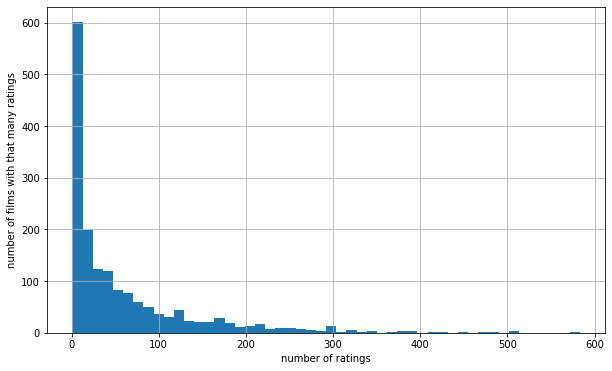

In [71]:
plt.figure(figsize=[10,6]) # Using basic pandas visualisation
ratings_df['num_of_ratings'].hist(bins=50)
plt.xlabel('number of ratings')
plt.ylabel('number of films with that many ratings')

So we see a long tailed distribution skewed to high numbers of ratings (think 'Star Wars').  Most movies have few ratings. 

Now let's look at the distribution of film ratings...

Text(0, 0.5, 'number of films with that rating')

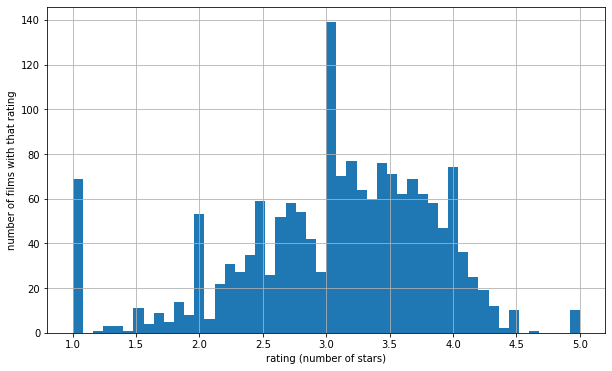

In [72]:
plt.figure(figsize=[10,6])
ratings_df.average_rating.hist(bins=50)
plt.xlabel('rating (number of stars)')
plt.ylabel('number of films with that rating')

This is interesting - the film rating data looks _sort of_ normally distributed but with spikes at integer values.

Why would we get high numbers of integer values?  These will be the films that have got just one review (and these films form the majority of our dataset!).

Once films have more than one rating, we calculate an average and therefore we (probably) no longer have a whole number.  

We having been thinking about two things:

    i)  average rating a film has
    ii) the number of ratings

What is the relationship betweeen these two measures?  Let's use a jointplot to see what sort of correlation there is, if any...

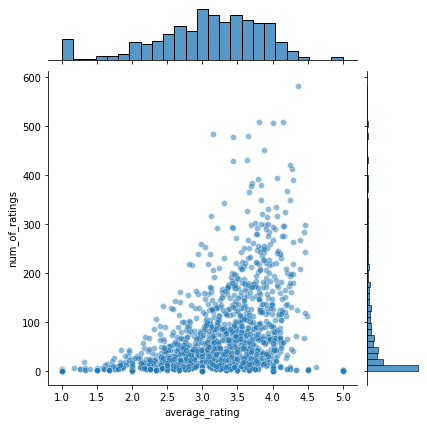

In [73]:
sns.jointplot(x='average_rating',y='num_of_ratings', data=ratings_df, alpha=0.5)

From the above, it looks like films with more ratings correlate to films with higher average ratings.  
This makes sense, because more people will inevitably be drawn to watching those films that have higher ratings, and people will tend to avoid films that ratings suggest are bad.

## 5) Create recommender

We want to build a recomendation system based on item similarity (content-based recommender).

Let's create a matrix of ratings indexed by user ids in rows and film titles in columns (a bit like like an X matrix of _examples_ and _features_).

Let's review our original df again...

In [74]:
df.head()

,user_id,item_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [75]:
len(df.groupby(by='title')['rating'].count())

1664

We can convert _df_ into the equivalent of an X matrix using *.pivot_table()*...

In [76]:
user_movie_matrix = df.pivot_table(values='rating' , index='user_id' , columns='title' )
user_movie_matrix.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN


Note: Lots of missing values - because most people have not seen most of the movies.
We have thus created a sparse matrix.   

Let's use our *ratings_df* dataframe and look at the films with the highest numbers of ratings...

In [77]:
ratings_df.sort_values(by='num_of_ratings', ascending=False).head()

,average_rating,num_of_ratings
title,,
Star Wars (1977),4.358491,583
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485


Let's focus on ratings from all individual users, for a couple of the popular movies listed above.  We'll get individual ratings for user from our other df - _moviematrix_.  

We'll look at Star Wars and Fargo and grab the ratings for all users...

In [78]:
starwars_user_ratings = user_movie_matrix['Star Wars (1977)']
fargo_user_ratings = user_movie_matrix['Fargo (1996)']

In [79]:
starwars_user_ratings.head(15)

user_id
1     5.0
2     5.0
3     NaN
4     5.0
5     4.0
6     4.0
7     5.0
8     5.0
9     5.0
10    5.0
11    NaN
12    4.0
13    5.0
14    5.0
15    5.0
Name: Star Wars (1977), dtype: float64

In [80]:
fargo_user_ratings.head()

user_id
1    5.0
2    5.0
3    NaN
4    NaN
5    5.0
Name: Fargo (1996), dtype: float64

So we can basically create a profile for each movie based on how the entirety of users rated it.

What's more interesting is that we can look at the correlation between 2 such series.

pandas has 2 corr methods:
- ._corr()_    pairwise correlation between columns in **one df**
- ._corrwith()_   pairwise correlation between rows or columns of **two DataFrame objects** 

We can use _.corrwith()_ to get correlation between 2 DataFrame objects (note that both Series and DataFrames are DataFrame objects but it is a dataframe object).  Here are the types of the objects we are dealing with... 

In [81]:
type(user_movie_matrix), type(user_movie_matrix['Star Wars (1977)' ]), type(starwars_user_ratings)

(pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.series.Series)

Let's now look at the correlation between our pandas Series of Star Wars ratings for all users vs equivalent series of user ratings (i.e. the columns) for each and every film in the user_movie_matrix DataFrame...

In [82]:
similar_to_starwars = user_movie_matrix.corrwith(starwars_user_ratings)
similar_to_starwars.head()

# Here we get a series which shows how each of the other movies correlate to Star Wars,
# This corr data is produced from the cols for each film which contain individual usder ratings

/Users/mac/opt/anaconda3/envs/recoxplainer/lib/python3.6/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/mac/opt/anaconda3/envs/recoxplainer/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


title
'Til There Was You (1997)    0.872872
1-900 (1994)                -0.645497
101 Dalmatians (1996)        0.211132
12 Angry Men (1957)          0.184289
187 (1997)                   0.027398
dtype: float64

The above line of code generates a series which shows how each of the other movies correlate to Star Wars.  

The correlation value between 'Star Wars' and 'Til There Was You (1997)' is 0.872872.  This value is  generated by comparing all of the 943 users' scores for Star Wars with all of the 943 users' scores for 'Til There Was You (1997)'.  

We can do the same thing between 'Star Wars' and every other film in the dataset. Each comparison between 2 films results in 1 corr coeff.  So there should be a correlation coefficient with each film.  There are 1664 films so there should be 1664 correlation coefficients (including self correlation).  Let's check...

In [83]:
similar_to_starwars.shape

(1664,)

As stated above, the corr data is produced by comparing our series (Star Wars all 943 user ratings) with each column from the moviematrix.  What, more generally, does this tell us? 

Here is a miniature _moviematrix_:


User ID   |    Star Wars    | 2001-Space Odyssey |  Endless Love
----------|-----------------|--------------------|----------------
  alice   |        5        |          5         |        0
   bob    |        3        |          2         |        5
  carol   |        5        |          5         |        1
   dai    |        5        |          4         |        2
  ellie   |        1        |          2         |        5



- Users 2 and 5 are romantics
- Users 1 and 3 like sci-fi
- User 4 likes exciting films

But it's important to be clear that our recommender is _content-based_.  We are fundamentally seeing how _similar_ one film is to another and that is the basis for the recommendation.

The alternative _collaborative_ approach would be _directly_ focused on correlations between _users_.

_Star Wars_ and _2001: Space Odyssey_ are higly correlated
_Endless Love_ is almost inversely correlated to the other two.

In this case we have 3 films so our *correlations\_with\_star\_wars* series will therefore have 3 elements, one for each of the other 2 films and also one for the self-correlation score (where correlation = 1). 

In [84]:
similar_to_fargo = user_movie_matrix.corrwith(fargo_user_ratings)

Let's do some tidying up here.  We'll create a dataframe to use (rather than a series as used above)...

In [85]:
corr_starwars = pd.DataFrame(similar_to_starwars, columns=['Correlation'])

In [86]:
corr_starwars.head(10)

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398
2 Days in the Valley (1996),0.066654
"20,000 Leagues Under the Sea (1954)",0.289768
2001: A Space Odyssey (1968),0.230884
3 Ninjas: High Noon At Mega Mountain (1998),NaN


In [87]:
corr_starwars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1664 entries, 'Til There Was You (1997) to Á köldum klaka (Cold Fever) (1994)
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Correlation  1410 non-null   float64
dtypes: float64(1)
memory usage: 26.0+ KB


From _.info()_ we can see we have lots of null values (obvious example case being a film which has got a rating by only 1 user and that user has not reviewed Star Wars.)  

Let's drop the null values...

In [88]:
corr_starwars.dropna(inplace=True)
corr_starwars.head(10)

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398
2 Days in the Valley (1996),0.066654
"20,000 Leagues Under the Sea (1954)",0.289768
2001: A Space Odyssey (1968),0.230884
"39 Steps, The (1935)",0.106453


We can put our similar films in descending order of correlation, so we can see better 'matches'...

In [89]:
corr_starwars.sort_values(by='Correlation', ascending=False).head(10)

,Correlation
title,
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Man of the Year (1995),1.0
Hollow Reed (1996),1.0
"Beans of Egypt, Maine, The (1994)",1.0
"Good Man in Africa, A (1994)",1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0


 So this looks like it contains some useful but it may also contain results based on films that have very few reviews.
 eg User 'Joe Bloggs' has watched Star Wars and given it 5 stars then also watched a film that no-one else has seen and also given it 5 stars.

It might make sense to exclude films with less than a certain number of ratings.  Let's review the histogram of number of ratings...

Text(0, 0.5, 'number of films with that many ratings')

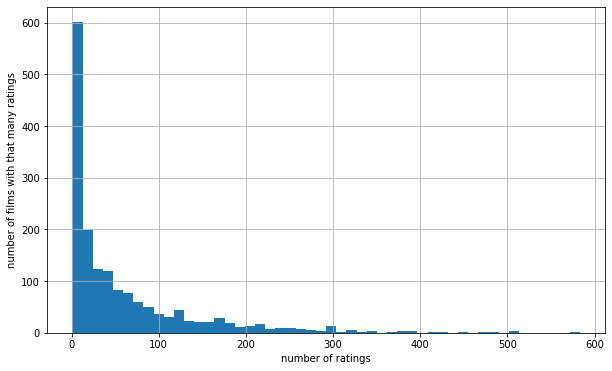

In [90]:
plt.figure(figsize=[10,6]) # Using basic pandas visualisation
ratings_df['num_of_ratings'].hist(bins=50)
plt.xlabel('number of ratings')
plt.ylabel('number of films with that many ratings')

From looking at the above plot, we might want to focus on films with more than 50 reviews.  First let's add a column to our Star Wars correlation df to show number of ratings...

In [91]:
corr_starwars = corr_starwars.join(ratings_df['num_of_ratings'])
corr_starwars.head()

# Note: it's easy to use join here instead of merge because we have title as index which makes join a good choice

,Correlation,num_of_ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


Now let's filter out films with 50 reviews or less...

In [92]:
new_corr_starwars = corr_starwars[corr_starwars['num_of_ratings'] > 50]

In [93]:
new_corr_starwars.head(10)

,Correlation,num_of_ratings
title,,
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
2 Days in the Valley (1996),0.066654,93
"20,000 Leagues Under the Sea (1954)",0.289768,72
2001: A Space Odyssey (1968),0.230884,259
"39 Steps, The (1935)",0.106453,59
Absolute Power (1997),0.085440,127
"Abyss, The (1989)",0.203709,151
Ace Ventura: Pet Detective (1994),0.062689,103


Let's put this into descending order, so we can get a better appreciation of how well our recommender is working...

In [94]:
new_corr_starwars.sort_values('Correlation',ascending=False).head(20)

,Correlation,num_of_ratings
title,,
Star Wars (1977),1.000000,583
"Empire Strikes Back, The (1980)",0.747981,367
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Giant (1956),0.488093,51
"Life Less Ordinary, A (1997)",0.411638,53
Austin Powers: International Man of Mystery (1997),0.377433,130
"Sting, The (1973)",0.367538,241
Indiana Jones and the Last Crusade (1989),0.350107,331


Perhaps we might want to increase our number of ratings filter since Shadowlands (78 ratings) and Giant (51 ratings) seem unexpectedly high....

In [95]:
new_corr_starwars = corr_starwars[corr_starwars['num_of_ratings'] > 100]
new_corr_starwars.sort_values('Correlation',ascending=False).head(20)

,Correlation,num_of_ratings
title,,
Star Wars (1977),1.000000,583
"Empire Strikes Back, The (1980)",0.747981,367
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130
"Sting, The (1973)",0.367538,241
Indiana Jones and the Last Crusade (1989),0.350107,331
Pinocchio (1940),0.347868,101
"Frighteners, The (1996)",0.332729,115


It looks like our recommender is mostly suggesting blockbusters (or 'Christmas films'?), which is perhaps not surprising. Perhaps a better test would be a film that was less of a blockbuster and appealed to more specific tastes.

Given that we want to be able to use our recommender with other films, let's bundle statements used above into a function...

In [96]:
def recommender(film_x, min_num_reviews):
    
    # Get user ratings for film
    film_x_user_ratings = user_movie_matrix[film_x]
    # Create pandas series of correlations for all films with film_x
    similar_to_film_x = user_movie_matrix.corrwith(film_x_user_ratings)
    # Convert to df
    corr_film_x = pd.DataFrame(similar_to_film_x, columns=['Correlation'])
    # Drop nulls
    corr_film_x.dropna(inplace=True)
    # Join ratings info to enbale filtering of films with low nums of ratings
    corr_film_x = corr_film_x.join(ratings_df['num_of_ratings'])
    # Apply filter
    new_corr_film_x = corr_film_x[corr_film_x['num_of_ratings'] >= min_num_reviews]
    # Sort intp ascending order
    return new_corr_film_x.sort_values('Correlation',ascending=False).head(20)

# Left as original statements here so as to explicitly show steps.  Could be condensed into fewer lines.

Test the function...

In [97]:
recommender('Star Wars (1977)', 100)

/Users/mac/opt/anaconda3/envs/recoxplainer/lib/python3.6/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/mac/opt/anaconda3/envs/recoxplainer/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation,num_of_ratings
title,,
Star Wars (1977),1.000000,583
"Empire Strikes Back, The (1980)",0.747981,367
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130
"Sting, The (1973)",0.367538,241
Indiana Jones and the Last Crusade (1989),0.350107,331
Pinocchio (1940),0.347868,101
"Frighteners, The (1996)",0.332729,115


Let's look at 'Fargo (1996)'...

In [98]:
recommender('Fargo (1996)', 200)

/Users/mac/opt/anaconda3/envs/recoxplainer/lib/python3.6/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/mac/opt/anaconda3/envs/recoxplainer/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation,num_of_ratings
title,,
Fargo (1996),1.000000,508
"People vs. Larry Flynt, The (1996)",0.341784,215
Stand by Me (1986),0.332730,227
Amadeus (1984),0.308669,276
2001: A Space Odyssey (1968),0.299882,259
"Graduate, The (1967)",0.295198,239
Raising Arizona (1987),0.293711,256
Young Frankenstein (1974),0.287904,200
"Clockwork Orange, A (1971)",0.279690,221


The above seem (to me!) not bad for the first 5 -10 recommendations.

Now let's try a few quite specific films...

In [99]:
recommender('12 Angry Men (1957)', 200)

/Users/mac/opt/anaconda3/envs/recoxplainer/lib/python3.6/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/mac/opt/anaconda3/envs/recoxplainer/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation,num_of_ratings
title,,
Rear Window (1954),0.570513,209
Evita (1996),0.355487,259
"Birdcage, The (1996)",0.351056,293
"Sting, The (1973)",0.344150,241
"English Patient, The (1996)",0.336269,481
Toy Story (1995),0.334943,452
"Boot, Das (1981)",0.322201,201
Butch Cassidy and the Sundance Kid (1969),0.317066,216
Psycho (1960),0.314124,239


We see the recommender picking up on 'classic dramas'. 

In [100]:
recommender('Clerks (1994)', 200)

/Users/mac/opt/anaconda3/envs/recoxplainer/lib/python3.6/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/mac/opt/anaconda3/envs/recoxplainer/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation,num_of_ratings
title,,
"Sting, The (1973)",0.399328,241
"People vs. Larry Flynt, The (1996)",0.388320,215
"Usual Suspects, The (1995)",0.356556,267
"Time to Kill, A (1996)",0.345830,232
Butch Cassidy and the Sundance Kid (1969),0.342085,216
Brazil (1985),0.340136,208
Heat (1995),0.335561,223
"Game, The (1997)",0.335032,251
Apocalypse Now (1979),0.323420,221


For more of a niche film like Clerks, we need to adjust our minimum num of ratings threshold as similar films may also only have not so many reviews. Let's drop threshold to 50...

In [101]:
recommender('Clerks (1994)', 50)

/Users/mac/opt/anaconda3/envs/recoxplainer/lib/python3.6/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/mac/opt/anaconda3/envs/recoxplainer/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation,num_of_ratings
title,,
Clerks (1994),1.000000,148
Forbidden Planet (1956),0.670241,67
Excess Baggage (1997),0.645497,52
I Know What You Did Last Summer (1997),0.643809,100
Heavy Metal (1981),0.631165,73
Things to Do in Denver when You're Dead (1995),0.576836,71
"Magnificent Seven, The (1954)",0.572713,121
"American Werewolf in London, An (1981)",0.571524,99
"Brothers McMullen, The (1995)",0.571100,73


The above results appear to be an improvement and seem to be pulling in more specialist/cult films.

In [102]:
recommender('Shine (1996)', 50)

/Users/mac/opt/anaconda3/envs/recoxplainer/lib/python3.6/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/mac/opt/anaconda3/envs/recoxplainer/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation,num_of_ratings
title,,
Shine (1996),1.000000,129
Desperate Measures (1998),0.904534,72
Anastasia (1997),0.853389,66
"American in Paris, An (1951)",0.717511,50
Hercules (1997),0.691902,66
"Fox and the Hound, The (1981)",0.674120,61
Jaws 2 (1978),0.655071,66
Daylight (1996),0.646221,57
"Quiet Man, The (1952)",0.626870,67


In [103]:
recommendations = recommender('Shine (1996)', 50).head()

/Users/mac/opt/anaconda3/envs/recoxplainer/lib/python3.6/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/mac/opt/anaconda3/envs/recoxplainer/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [104]:
recommendations

,Correlation,num_of_ratings
title,,
Shine (1996),1.000000,129
Desperate Measures (1998),0.904534,72
Anastasia (1997),0.853389,66
"American in Paris, An (1951)",0.717511,50
Hercules (1997),0.691902,66
